In [2]:
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import numpy as np
import pandas as pd

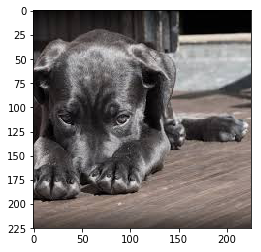

In [88]:
#originaldata = pd.read_csv('./Apparel/apparel-trainval.csv')
#traindata = np.array(originaldata)[:48000,1:]
#image = traindata[0]
image = plt.imread('./labrdr.jpg','jpg')
#image_resized = misc.imresize(image, (32, 32))
plt.imshow(image)
#print(image_resized.shape)

In [89]:
#image = image.reshape((32,32,1))
print(image.T.shape)

(3, 225, 225)


In [92]:
class CNN: 
    def randomFilter(self,numberOfFilters,depth):
        randomList = []
        for i in range(0,numberOfFilters):
            randomList.append(np.random.randn(depth,5,5))  #changed depth to 0th axis
        return randomList
    
    def convolution(self,imageInput,filters,stride):
        rowstride = 0
        colstride = 0
        listOfConvl = []
        convmat = []
        filterSize = 5
        for filt in filters:
            rowstride=0
            convmat = []
            while rowstride+filterSize <= imageInput.shape[1]: #changed from 0 to 1
                colstride = 0
                while colstride+filterSize <= imageInput.shape[2]: #changed from 1 to 2
                    mat = imageInput[:,rowstride:rowstride+filterSize,\
                                     colstride:colstride+filterSize]
                    convmat.append(np.sum(np.multiply(mat,filt)))
                    colstride+=stride
                rowstride+=stride
            convmat = np.array(convmat)
            #convmat = self.activationFunc(convmat,'relu')
            filteredmatshape = imageInput.shape[1]-np.array(filt).shape[1]+1 #changed 0 to 1
            convmat = convmat.reshape((filteredmatshape,filteredmatshape))
            listOfConvl.append(convmat)
        return listOfConvl 
    
    def maxpool(self,outputs,stride):
        rowstride = 0
        colstride = 0
        listOfConvl = []
        convmat = []
        poolSize = 2
        for output in outputs:
            rowstride=0
            convmat = []
            while rowstride+poolSize <= output.shape[0]:
                colstride = 0
                while colstride+poolSize <= output.shape[1]:
                    mat = output[rowstride:rowstride+poolSize,\
                                     colstride:colstride+poolSize]
                    convmat.append(np.max(mat))
                    colstride+=stride
                rowstride+=stride
            convmat = np.array(convmat)
            filteredmatshape = int(np.sqrt(convmat.shape[0]))
            convmat = convmat.reshape((filteredmatshape,filteredmatshape))
            listOfConvl.append(convmat)
        return listOfConvl
    
    
    def activationFunc(self,X,activation):
        if activation == 'relu':
            return X*(X>0)/10
        if activation == 'softmax':
            ycap = ycap.transpose()
            for row in range(0,ycap.shape[0]):
                ycap[row] = ycap[row]-max(ycap[row])
                ycap[row] = np.exp(ycap[row])/sum(np.exp(ycap[row]))
            return(ycap.transpose())
        
    def feedforwardNN(self,a,weights,biases):
        for weight,bias in zip(weights,biases):
            z = np.dot(weight,a)+bias
            a = self.activationFunc(z,'relu')
    
    def showImage(self,imageInput):
        #imageInput = imageInput.T
        #print("orig",imageInput.shape)
        for i in range(0,imageInput.shape[0]):
            newImage = imageInput[i].T
            #print(newImage.shape)
            plt.figure()
            plt.imshow(newImage)
            plt.show
            
    def feedforward(self,imageInput,numberOfFilters,NNlayers):
        #strides is an array of strides at every convl layer 
        convStride = 1
        poolStride = 2
        numOfLayers = len(numberOfFilters)
        for ind in range(0,numOfLayers):
            #Convolution
            #print("Input Layer",imageInput.shape)
            depth = imageInput.shape[0]  #changed from 2 to 0
            filters = self.randomFilter(numberOfFilters[ind],depth)
            outputs = self.convolution(imageInput,filters,convStride)
            self.showImage(np.array(outputs))
            #MaxPool
            maxoutputs = self.maxpool(outputs,poolStride)
            imageInput = np.array(maxoutputs)
            self.showImage(imageInput)
            #imageInput = imageInput
        #print("Input Layer",imageInput.shape)
        
        #Flatten
        pixels = imageInput.shape[0] * imageInput.shape[1] * imageInput.shape[2]
        imageInput = imageInput.reshape((1,pixels))
        #print("Flattened",imageInput.shape)
        
        #FeedForwardNN
        NNlayers.insert(0,imageInput.shape[0])
        layers = len(NNlayers)  #Number of layers
        biases = [np.random.randn(i,1) for i in NNlayers[1:]]  #Init Bias
        weights = [np.random.randn(i,j) for i,j in zip(NNlayers[1:],NNlayers[:-1])]
        self.feedforwardNN(imageInput,weights,biases)

Input Layer (3, 225, 225)
Input Layer (6, 110, 110)


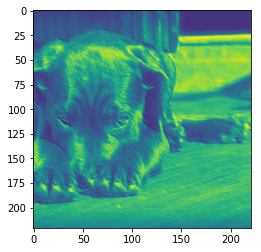

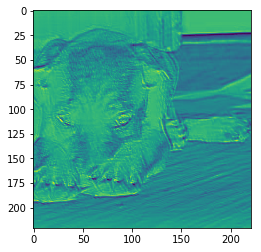

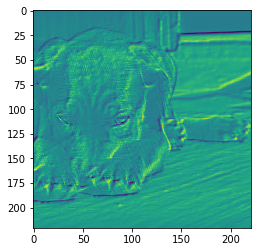

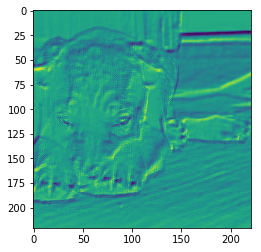

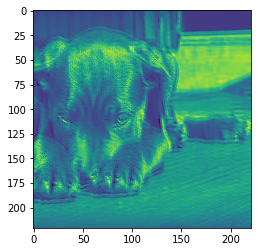

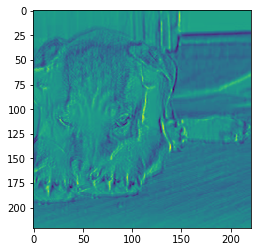

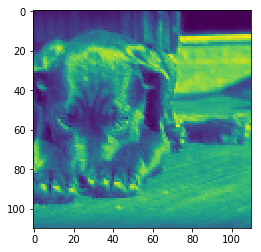

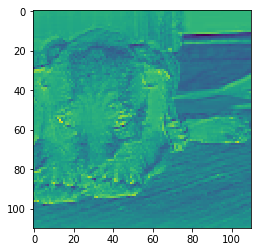

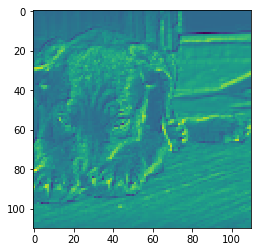

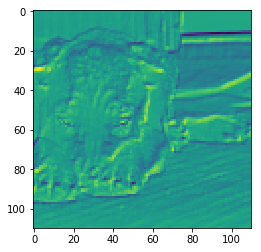

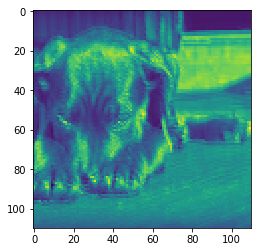

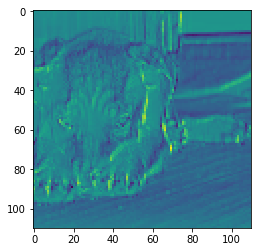

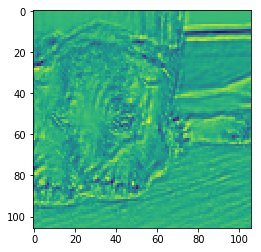

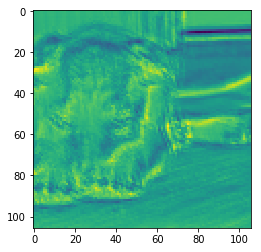

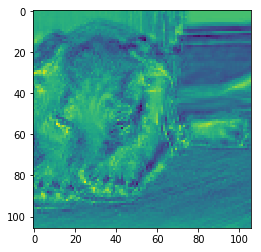

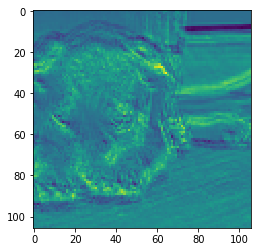

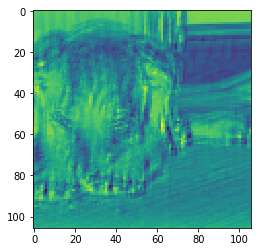

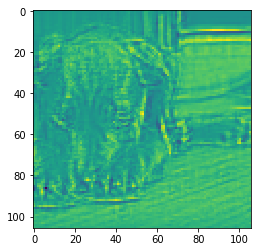

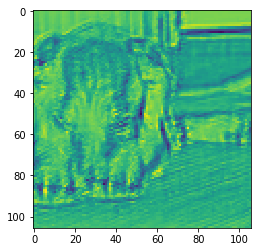

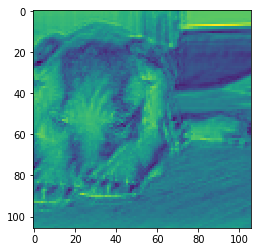

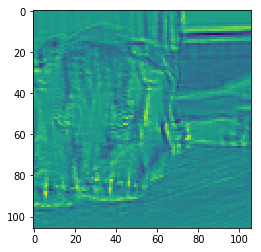

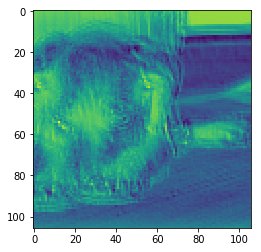

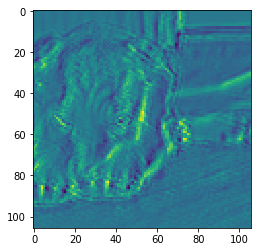

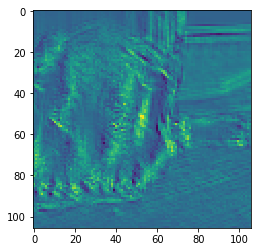

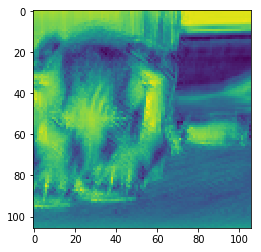

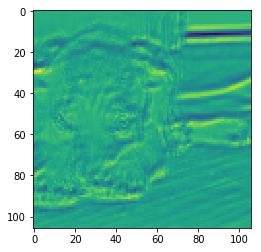

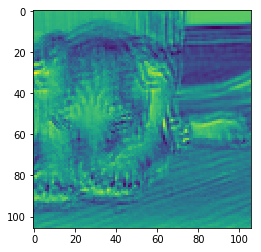

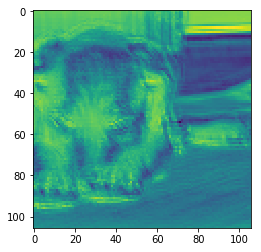

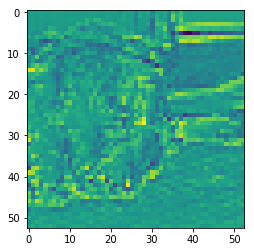

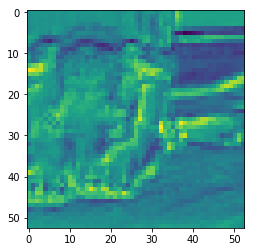

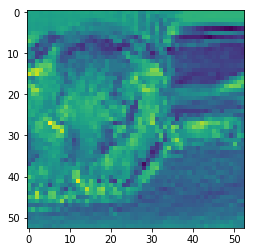

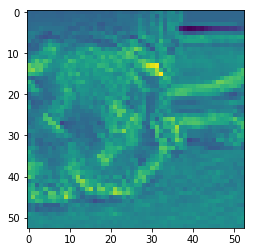

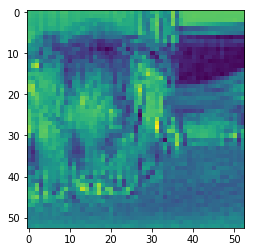

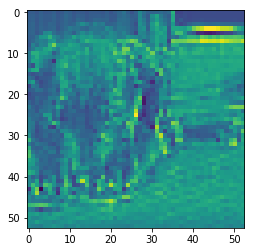

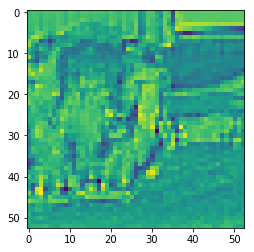

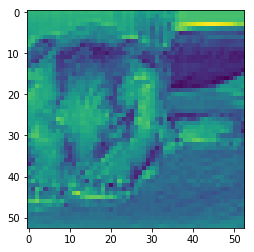

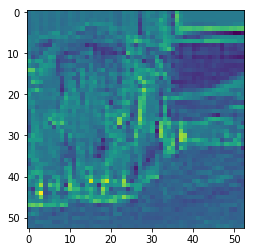

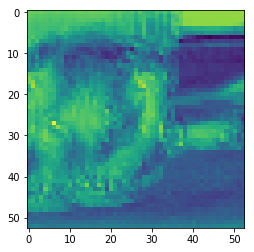

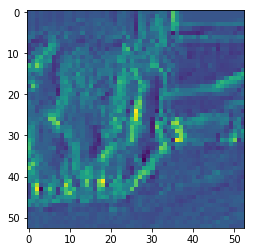

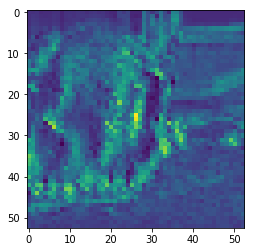

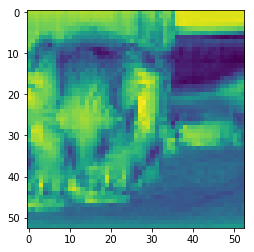

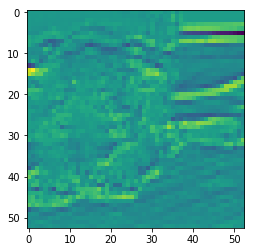

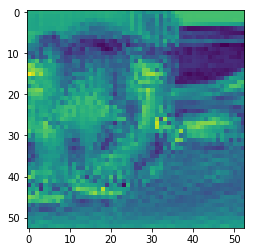

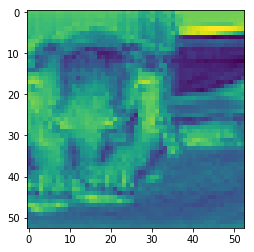

In [93]:
a = CNN()
a.feedforward(image.T,[6,16],[120,84,10])